In [1]:

# Setup & Dataset Creation
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import resample

np.random.seed(42)
n = 1200

genders = ["Male", "Female", "Non-binary"]
ethnicities = ["Group_A", "Group_B", "Group_C"]
degrees = ["High School", "Bachelors", "Masters", "PhD"]

data = pd.DataFrame({
    "Applicant_ID": range(1, n+1),
    "Gender": np.random.choice(genders, n, p=[0.5, 0.45, 0.05]),
    "Ethnicity": np.random.choice(ethnicities, n, p=[0.4, 0.35, 0.25]),
    "Age": np.random.randint(20, 60, n),
    "Degree": np.random.choice(degrees, n, p=[0.2, 0.5, 0.25, 0.05]),
    "Years_Experience": np.random.randint(0, 20, n),
    "Skill_Test_Score": np.random.randint(40, 100, n)
})

# Bias mechanism in label generation (for exercise realism)
data["Shortlisted"] = np.where(
    ((data["Ethnicity"] == "Group_A") & (data["Skill_Test_Score"] > 70)) |
    ((data["Gender"] == "Male") & (data["Years_Experience"] > 5)),
    np.random.choice([1, 0], n, p=[0.7, 0.3]),
    np.random.choice([1, 0], n, p=[0.4, 0.6])
)

print("Preview:")
display(data.head())
print("\nClass balance (Shortlisted):")
print(data["Shortlisted"].value_counts(normalize=True).round(3))


Preview:


,Applicant_ID,Gender,Ethnicity,Age,Degree,Years_Experience,Skill_Test_Score,Shortlisted
0,1,Male,Group_C,50,High School,18,84,1
1,2,Non-binary,Group_A,46,Bachelors,4,59,0
2,3,Female,Group_A,30,High School,17,63,0
3,4,Female,Group_A,57,Masters,19,66,0
4,5,Male,Group_B,24,Bachelors,11,69,1



Class balance (Shortlisted):
Shortlisted
1    0.533
0    0.467
Name: proportion, dtype: float64


In [2]:

# Task 1: Understanding Types of Bias (quick reference printout)
# =========================================================

print("Data Bias: Skewed/underrepresented groups or biased labels from historical processes.")
print("Algorithmic Bias: Modeling choices (features, thresholds) induce uneven errors across groups.")
print("Societal Bias: Pre-existing inequalities reflected in data (education access, experience).")
print("\nPotential pre-training bias here: minority group sizes (e.g., Non-binary), label rule favoring Group_A & Males.")


Data Bias: Skewed/underrepresented groups or biased labels from historical processes.
Algorithmic Bias: Modeling choices (features, thresholds) induce uneven errors across groups.
Societal Bias: Pre-existing inequalities reflected in data (education access, experience).

Potential pre-training bias here: minority group sizes (e.g., Non-binary), label rule favoring Group_A & Males.


Gender distribution:


,proportion
Gender,
Male,0.490000
Female,0.460833
Non-binary,0.049167



Ethnicity distribution:


,proportion
Ethnicity,
Group_A,0.390000
Group_B,0.368333
Group_C,0.241667


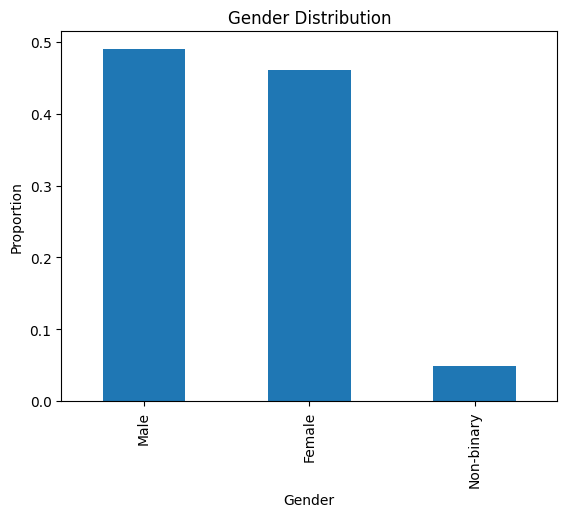

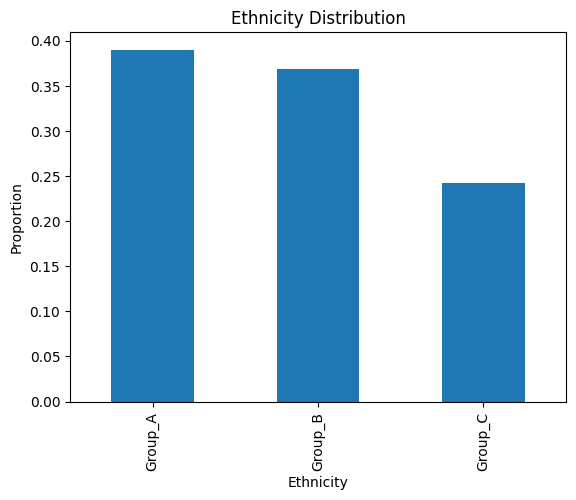

In [3]:

# Task 2.1: Detecting Bias in Data (distributions)
# =========================================================

# Proportions by group
gender_dist = data["Gender"].value_counts(normalize=True).rename("proportion")
ethnicity_dist = data["Ethnicity"].value_counts(normalize=True).rename("proportion")

print("Gender distribution:")
display(gender_dist)
print("\nEthnicity distribution:")
display(ethnicity_dist)

# Plots
ax = gender_dist.plot(kind='bar', title='Gender Distribution')
plt.ylabel('Proportion'); plt.show()

ax = ethnicity_dist.plot(kind='bar', title='Ethnicity Distribution')
plt.ylabel('Proportion'); plt.show()


Shortlist rates by Gender:


,Shortlisted
Gender,
Female,0.446655
Male,0.632653
Non-binary,0.355932



Shortlist rates by Ethnicity:


,Shortlisted
Ethnicity,
Group_A,0.602564
Group_B,0.475113
Group_C,0.510345



Chi-square p-value (Gender vs Shortlisted): 4.949e-11
Chi-square p-value (Ethnicity vs Shortlisted): 4.001e-04


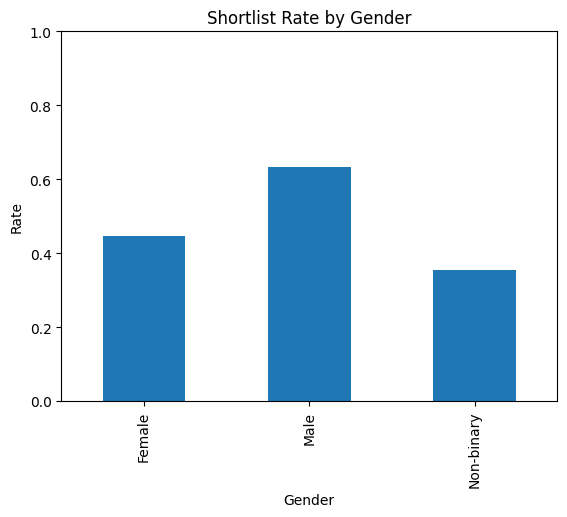

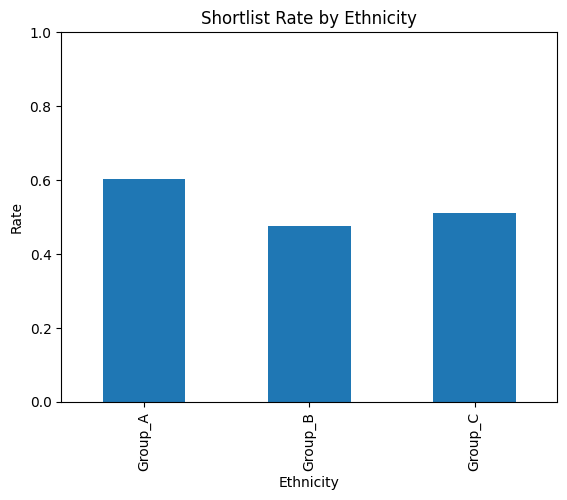

In [4]:
# =========================================================
# Task 2.2 & 2.3: Shortlist Rates by Group + Chi-square tests
# =========================================================

# Shortlist rates
rate_gender = data.groupby("Gender")["Shortlisted"].mean().sort_index()
rate_ethn = data.groupby("Ethnicity")["Shortlisted"].mean().sort_index()

print("Shortlist rates by Gender:")
display(rate_gender)
print("\nShortlist rates by Ethnicity:")
display(rate_ethn)

# Chi-square tests
ct_gender = pd.crosstab(data["Gender"], data["Shortlisted"])
ct_ethn = pd.crosstab(data["Ethnicity"], data["Shortlisted"])

chi2_g, p_g, *_ = chi2_contingency(ct_gender)
chi2_e, p_e, *_ = chi2_contingency(ct_ethn)

print(f"\nChi-square p-value (Gender vs Shortlisted): {p_g:.3e}")
print(f"Chi-square p-value (Ethnicity vs Shortlisted): {p_e:.3e}")

# Plots
rate_gender.plot(kind='bar', ylim=(0,1), title='Shortlist Rate by Gender')
plt.ylabel('Rate'); plt.show()

rate_ethn.plot(kind='bar', ylim=(0,1), title='Shortlist Rate by Ethnicity')
plt.ylabel('Rate'); plt.show()


In [5]:

# Task 3.1: Baseline Model (Logistic Regression)
# =========================================================

# Encode features (include sensitive features for baseline)
X = pd.get_dummies(data[["Gender","Ethnicity","Degree","Years_Experience","Skill_Test_Score","Age"]], drop_first=True)
y = data["Shortlisted"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

base_model = LogisticRegression(solver='liblinear', max_iter=500)
base_model.fit(X_train, y_train)

y_pred_base = base_model.predict(X_test)
y_proba_base = base_model.predict_proba(X_test)[:,1]

acc_base = accuracy_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, y_proba_base)

print(f"Baseline Accuracy: {acc_base:.3f} | AUC: {auc_base:.3f}")


Baseline Accuracy: 0.608 | AUC: 0.631


In [6]:
#  Task 3.2 & 3.3: Group-wise Metrics (Accuracy, TPR, FPR) for Gender & Ethnicity
# =========================================================

# Bring sensitive columns for grouping on test rows
df_test = X_test.copy()
df_test["Gender"] = data.loc[y_test.index, "Gender"].values
df_test["Ethnicity"] = data.loc[y_test.index, "Ethnicity"].values

def group_metrics(df, y_true, y_pred, group_col):
    out = {}
    for g in sorted(df[group_col].unique()):
        idx = (df[group_col] == g).values
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()
        acc = (tp+tn)/(tp+tn+fp+fn)
        tpr = tp/(tp+fn) if (tp+fn) else 0.0
        fpr = fp/(fp+tn) if (fp+tn) else 0.0
        out[g] = {"Accuracy": acc, "TPR": tpr, "FPR": fpr, "Support": int(idx.sum())}
    return pd.DataFrame(out)

print("Baseline metrics by Gender:")
display(group_metrics(df_test, y_test, y_pred_base, "Gender"))

print("\nBaseline metrics by Ethnicity:")
display(group_metrics(df_test, y_test, y_pred_base, "Ethnicity"))

# Feature importances (coefficients)
coef_base = pd.Series(base_model.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nTop positive coefficients (baseline):")
display(coef_base.head(10))
print("\nTop negative coefficients (baseline):")
display(coef_base.tail(10))


Baseline metrics by Gender:


,Female,Male,Non-binary
Accuracy,0.557576,0.651685,0.647059
TPR,0.361111,0.929204,0.285714
FPR,0.290323,0.830769,0.100000
Support,165.000000,178.000000,17.000000



Baseline metrics by Ethnicity:


,Group_A,Group_B,Group_C
Accuracy,0.589041,0.645390,0.575342
TPR,0.850000,0.520548,0.692308
FPR,0.727273,0.220588,0.558824
Support,146.000000,141.000000,73.000000



Top positive coefficients (baseline):


,0
Gender_Male,0.725944
Years_Experience,0.033080
Skill_Test_Score,0.014770
Age,-0.000263
Degree_PhD,-0.011729
Degree_High School,-0.083142
Degree_Masters,-0.094127
Gender_Non-binary,-0.339418
Ethnicity_Group_C,-0.516040
Ethnicity_Group_B,-0.706001



Top negative coefficients (baseline):


,0
Gender_Male,0.725944
Years_Experience,0.033080
Skill_Test_Score,0.014770
Age,-0.000263
Degree_PhD,-0.011729
Degree_High School,-0.083142
Degree_Masters,-0.094127
Gender_Non-binary,-0.339418
Ethnicity_Group_C,-0.516040
Ethnicity_Group_B,-0.706001


In [7]:
#  — Task 4 (Mitigation, Pre-processing): Group Balancing via Upsampling
# =========================================================

# Upsample Ethnicity groups to the max group count
def upsample_to_max(df, col):
    groups = df[col].value_counts()
    max_n = groups.max()
    frames = []
    for g, n_g in groups.items():
        part = df[df[col]==g]
        if n_g < max_n:
            part = resample(part, replace=True, n_samples=max_n, random_state=42)
        frames.append(part)
    return pd.concat(frames, ignore_index=True)

# Apply to Ethnicity (and optionally to Gender)
data_bal = upsample_to_max(data, "Ethnicity")
data_bal = upsample_to_max(data_bal, "Gender")  # optional extra balancing

print("Balanced group proportions:")
print("Ethnicity:\n", data_bal["Ethnicity"].value_counts(normalize=True).round(3))
print("\nGender:\n", data_bal["Gender"].value_counts(normalize=True).round(3))

Balanced group proportions:
Ethnicity:
 Ethnicity
Group_B    0.343
Group_A    0.332
Group_C    0.325
Name: proportion, dtype: float64

Gender:
 Gender
Male          0.333
Female        0.333
Non-binary    0.333
Name: proportion, dtype: float64


In [8]:
# Task 4 (Mitigation, In-processing): Train with Sensitive Features Removed + Class Weight
# =========================================================

Xb = pd.get_dummies(
    data_bal[["Degree","Years_Experience","Skill_Test_Score","Age"]],  # drop Gender & Ethnicity as features
    drop_first=True
)
yb = data_bal["Shortlisted"].astype(int)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=42, stratify=yb)

inproc_model = LogisticRegression(solver='liblinear', max_iter=500, class_weight='balanced')
inproc_model.fit(Xb_train, yb_train)

yb_pred_in = inproc_model.predict(Xb_test)
yb_proba_in = inproc_model.predict_proba(Xb_test)[:,1]

acc_in = accuracy_score(yb_test, yb_pred_in)
auc_in = roc_auc_score(yb_test, yb_proba_in)

print(f"In-processing (no sensitive feats, class_weight) Accuracy: {acc_in:.3f} | AUC: {auc_in:.3f}")

# For fairness metrics by group, we need group columns aligned to test set indices
df_test_in = Xb_test.copy()
df_test_in["Gender"]   = data_bal.loc[yb_test.index, "Gender"].values
df_test_in["Ethnicity"]= data_bal.loc[yb_test.index, "Ethnicity"].values

print("\nIn-processing metrics by Ethnicity:")
display(group_metrics(df_test_in, yb_test, yb_pred_in, "Ethnicity"))

print("\nIn-processing metrics by Gender:")
display(group_metrics(df_test_in, yb_test, yb_pred_in, "Gender"))


In-processing (no sensitive feats, class_weight) Accuracy: 0.530 | AUC: 0.554

In-processing metrics by Ethnicity:


,Group_A,Group_B,Group_C
Accuracy,0.604762,0.471616,0.518135
TPR,0.551724,0.479167,0.586957
FPR,0.329787,0.533835,0.544554
Support,210.000000,229.000000,193.000000



In-processing metrics by Gender:


,Female,Male,Non-binary
Accuracy,0.621762,0.440191,0.534783
TPR,0.584270,0.456522,0.636364
FPR,0.346154,0.591549,0.516340
Support,193.000000,209.000000,230.000000


In [9]:
#  Task 4 (Mitigation, Post-processing): Group-specific Thresholding (Demographic Parity target)
# =========================================================

# Use baseline model's probabilities & groups to set per-group thresholds
scores = pd.Series(y_proba_base, index=y_test.index, name="score")
groups_ethn = data.loc[y_test.index, "Ethnicity"]
groups_gender = data.loc[y_test.index, "Gender"]

# Target: match global positive rate to move toward demographic parity
global_pos_rate = (y_pred_base == 1).mean()

def thresholds_for_target_rate(scores, groups, target_rate):
    thr = {}
    for g in sorted(groups.unique()):
        s_g = scores[groups == g].sort_values(ascending=False)
        k = max(int(np.floor(target_rate * len(s_g))), 0)
        t = s_g.iloc[k-1] if k > 0 else 1.1  # if no positives desired, set threshold above max
        thr[g] = float(t)
    return thr

ethn_thresholds = thresholds_for_target_rate(scores, groups_ethn, global_pos_rate)
gender_thresholds = thresholds_for_target_rate(scores, groups_gender, global_pos_rate)

def apply_group_thresholds(scores, groups, thresholds):
    preds = []
    for i in scores.index:
        g = groups.loc[i]
        preds.append(1 if scores.loc[i] >= thresholds[g] else 0)
    return np.array(preds, dtype=int)

y_pred_post_ethn = apply_group_thresholds(scores, groups_ethn, ethn_thresholds)
y_pred_post_gender = apply_group_thresholds(scores, groups_gender, gender_thresholds)

print("Post-processing (Ethnicity thresholds) Accuracy:", accuracy_score(y_test, y_pred_post_ethn))
print("Post-processing (Gender thresholds) Accuracy:", accuracy_score(y_test, y_pred_post_gender))

print("\nPost-processing thresholds (Ethnicity):", ethn_thresholds)
print("Post-processing thresholds (Gender):", gender_thresholds)


Post-processing (Ethnicity thresholds) Accuracy: 0.6055555555555555
Post-processing (Gender thresholds) Accuracy: 0.5666666666666667

Post-processing thresholds (Ethnicity): {'Group_A': 0.6080539241667, 'Group_B': 0.44092647500523424, 'Group_C': 0.5254752654821582}
Post-processing thresholds (Gender): {'Female': 0.43632357839237845, 'Male': 0.6204336739165176, 'Non-binary': 0.41738860581312687}


In [10]:
# Task 5.1: Define Fairness Metrics (DP, EO, DI)
# =========================================================

def demographic_parity(y_true, y_pred, groups):
    rates = pd.DataFrame({"y_pred": y_pred, "group": groups}).groupby("group")["y_pred"].mean()
    return float(rates.max() - rates.min())

def equal_opportunity(y_true, y_pred, groups):
    # TPR difference
    dfm = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "group": groups})
    tprs = {}
    for g in sorted(dfm["group"].unique()):
        sub = dfm[dfm["group"]==g]
        tp = ((sub["y_pred"]==1) & (sub["y_true"]==1)).sum()
        fn = ((sub["y_pred"]==0) & (sub["y_true"]==1)).sum()
        tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
        tprs[g] = tpr
    return float(max(tprs.values()) - min(tprs.values()))

def disparate_impact(y_true, y_pred, groups, privileged_group):
    # min(rate) / privileged_rate
    rates = pd.DataFrame({"y_pred": y_pred, "group": groups}).groupby("group")["y_pred"].mean()
    if privileged_group not in rates.index or rates[privileged_group] == 0:
        return np.nan
    return float(rates.min() / rates[privileged_group])


In [12]:

#  Task 5.2: Compute Metrics (Baseline vs In-processing vs Post-processing)
# =========================================================

# Baseline fairness (Ethnicity)
dp_base_ethn = demographic_parity(y_test.values, y_pred_base, groups_ethn)
eo_base_ethn = equal_opportunity(y_test.values, y_pred_base, groups_ethn)
di_base_ethn = disparate_impact(y_test.values, y_pred_base, groups_ethn, privileged_group="Group_A")

# In-processing fairness (Ethnicity) on balanced split
dp_in_ethn = demographic_parity(yb_test.values, yb_pred_in, df_test_in["Ethnicity"])
eo_in_ethn = equal_opportunity(yb_test.values, yb_pred_in, df_test_in["Ethnicity"])
di_in_ethn = disparate_impact(yb_test.values, yb_pred_in, df_test_in["Ethnicity"], privileged_group="Group_A")

# Post-processing fairness (Ethnicity thresholds) on original baseline test
dp_post_ethn = demographic_parity(y_test.values, y_pred_post_ethn, groups_ethn)
eo_post_ethn = equal_opportunity(y_test.values, y_pred_post_ethn, groups_ethn)
di_post_ethn = disparate_impact(y_test.values, y_pred_post_ethn, groups_ethn, privileged_group="Group_A")

print("=== Fairness Metrics (Ethnicity) ===")
print(f"Baseline         -> DP: {dp_base_ethn:.3f}, EO: {eo_base_ethn:.3f}, DI: {di_base_ethn:.3f}, Acc: {accuracy_score(y_test, y_pred_base):.3f}")
print(f"In-processing    -> DP: {dp_in_ethn:.3f}, EO: {eo_in_ethn:.3f}, DI: {di_in_ethn:.3f}, Acc: {accuracy_score(yb_test, yb_pred_in):.3f}")
print(f"Post-processing  -> DP: {dp_post_ethn:.3f}, EO: {eo_post_ethn:.3f}, DI: {di_post_ethn:.3f}, Acc: {accuracy_score(y_test, y_pred_post_ethn):.3f}")


=== Fairness Metrics (Ethnicity) ===
Baseline         -> DP: 0.419, EO: 0.329, DI: 0.473, Acc: 0.608
In-processing    -> DP: 0.112, EO: 0.108, DI: 1.000, Acc: 0.530
Post-processing  -> DP: 0.007, EO: 0.067, DI: 0.989, Acc: 0.606


In [13]:

#  Task 5.2 : Fairness Metrics for Gender as well
# =========================================================

# Baseline (Gender)
dp_base_gen = demographic_parity(y_test.values, y_pred_base, groups_gender)
eo_base_gen = equal_opportunity(y_test.values, y_pred_base, groups_gender)
di_base_gen = disparate_impact(y_test.values, y_pred_base, groups_gender, privileged_group="Male")

# In-processing on balanced split (Gender)
dp_in_gen = demographic_parity(yb_test.values, yb_pred_in, df_test_in["Gender"])
eo_in_gen = equal_opportunity(yb_test.values, yb_pred_in, df_test_in["Gender"])
di_in_gen = disparate_impact(yb_test.values, yb_pred_in, df_test_in["Gender"], privileged_group="Male")

# Post-processing with Gender thresholds on baseline
dp_post_gen = demographic_parity(y_test.values, y_pred_post_gender, groups_gender)
eo_post_gen = equal_opportunity(y_test.values, y_pred_post_gender, groups_gender)
di_post_gen = disparate_impact(y_test.values, y_pred_post_gender, groups_gender, privileged_group="Male")

print("=== Fairness Metrics (Gender) ===")
print(f"Baseline         -> DP: {dp_base_gen:.3f}, EO: {eo_base_gen:.3f}, DI: {di_base_gen:.3f}, Acc: {accuracy_score(y_test, y_pred_base):.3f}")
print(f"In-processing    -> DP: {dp_in_gen:.3f}, EO: {eo_in_gen:.3f}, DI: {di_in_gen:.3f}, Acc: {accuracy_score(yb_test, yb_pred_in):.3f}")
print(f"Post-processing  -> DP: {dp_post_gen:.3f}, EO: {eo_post_gen:.3f}, DI: {di_post_gen:.3f}, Acc: {accuracy_score(y_test, y_pred_post_gender):.3f}")


=== Fairness Metrics (Gender) ===
Baseline         -> DP: 0.717, EO: 0.643, DI: 0.198, Acc: 0.608
In-processing    -> DP: 0.101, EO: 0.180, DI: 0.908, Acc: 0.530
Post-processing  -> DP: 0.007, EO: 0.110, DI: 0.988, Acc: 0.567


In [15]:
#  Task 5.3 & Task 6: Compact Report Printout
# =========================================================

def summarize_results():
    print("=== SUMMARY (Ethnicity) ===")
    print(f"- Baseline:        Acc={accuracy_score(y_test, y_pred_base):.3f}, DP={demographic_parity(y_test.values, y_pred_base, groups_ethn):.3f}, EO={equal_opportunity(y_test.values, y_pred_base, groups_ethn):.3f}, DI={disparate_impact(y_test.values, y_pred_base, groups_ethn, 'Group_A'):.3f}")
    print(f"- In-processing:   Acc={accuracy_score(yb_test, yb_pred_in):.3f}, DP={demographic_parity(yb_test.values, yb_pred_in, df_test_in['Ethnicity']):.3f}, EO={equal_opportunity(yb_test.values, yb_pred_in, df_test_in['Ethnicity']):.3f}, DI={disparate_impact(yb_test.values, yb_pred_in, df_test_in['Ethnicity'],'Group_A'):.3f}")
    print(f"- Post-processing: Acc={accuracy_score(y_test, y_pred_post_ethn):.3f}, DP={demographic_parity(y_test.values, y_pred_post_ethn, groups_ethn):.3f}, EO={equal_opportunity(y_test.values, y_pred_post_ethn, groups_ethn):.3f}, DI={disparate_impact(y_test.values, y_pred_post_ethn, groups_ethn,'Group_A'):.3f}")
    print("\nNOTES:")
    print("- DP  measures difference in positive rates across groups.")
    print("- EO  measures difference in TPR across groups.")
    print("- DI  compares min positive rate to privileged group's rate (≥0.8 often cited).")
    print("- Expect trade-offs: fairness gains may reduce raw accuracy slightly.")

summarize_results()


=== SUMMARY (Ethnicity) ===
- Baseline:        Acc=0.608, DP=0.419, EO=0.329, DI=0.473
- In-processing:   Acc=0.530, DP=0.112, EO=0.108, DI=1.000
- Post-processing: Acc=0.606, DP=0.007, EO=0.067, DI=0.989

NOTES:
- DP  measures difference in positive rates across groups.
- EO  measures difference in TPR across groups.
- DI  compares min positive rate to privileged group's rate (≥0.8 often cited).
- Expect trade-offs: fairness gains may reduce raw accuracy slightly.
